In [ ]:
# ! pip install langchain_mistralai

In [12]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"

### The Schema

we need to describe what information we want to extract from the text. Pydantic to define an example schema to extarct personal information

In [13]:
from typing import Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class Person(BaseModel):
    """Information about a person."""

    # ^ Doc-string for the entity Person.
    # This doc-string is sent to the LLM as the description of the schema Person,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(
        default=None, description="The color of the person's hair if known"
    )
    height_in_meters: Optional[str] = Field(
        default=None, description="Height measured in meters"
    )

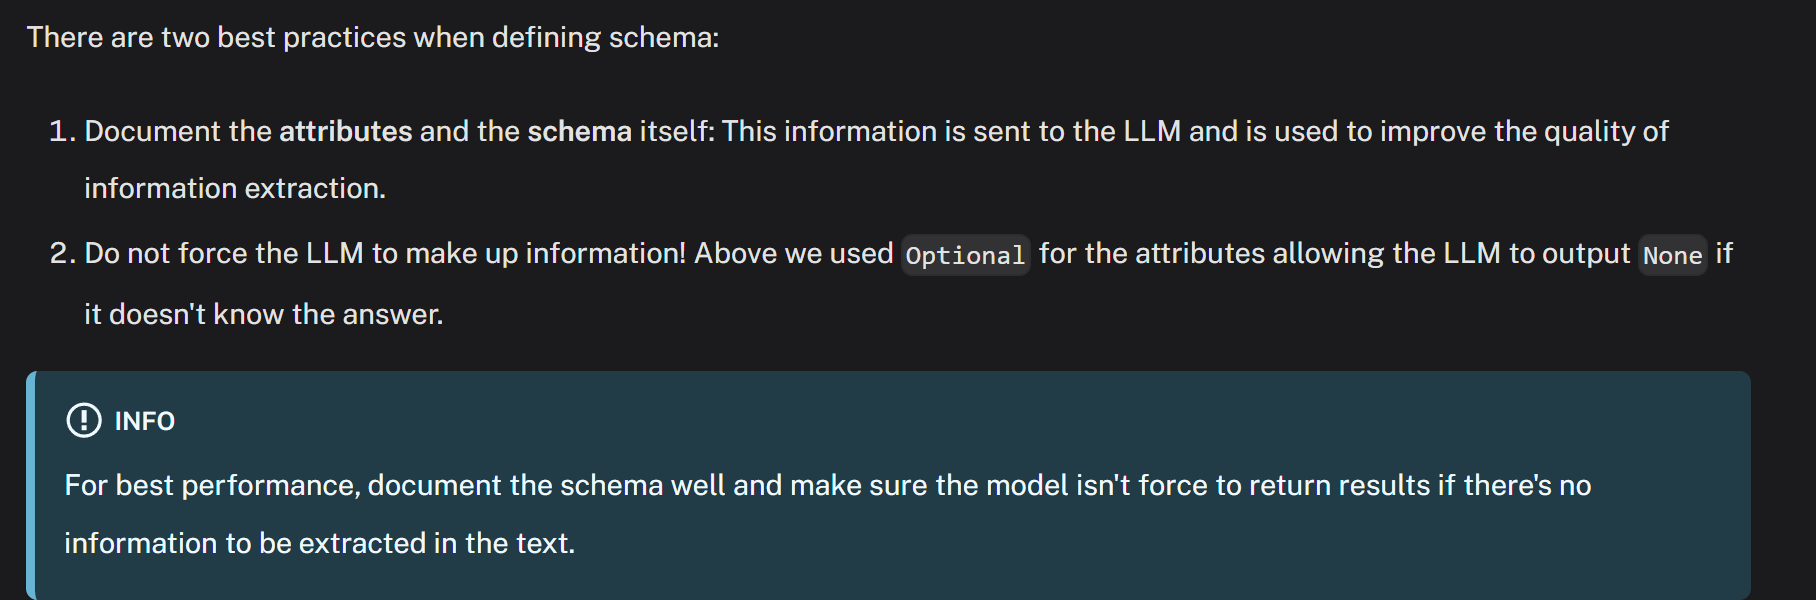

### The Extractor

In [14]:
from typing import Optional

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field

# Define a custom prompt to provide instructions and any additional context.
# 1) You can add examples into the prompt template to improve extraction quality
# 2) Introduce additional parameters to take context into account (e.g., include metadata
#    about the document from which the text was extracted.)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the text. "
            "If you do not know the value of an attribute asked to extract, "
            "return null for the attribute's value.",
        ),
        # Please see the how-to about improving performance with
        # reference examples.
        # MessagesPlaceholder('examples'),
        ("human", "{text}"),
    ]
)

In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

runnable = prompt | llm.with_structured_output(schema=Person)

In [16]:
text = "Alan Smith is 6 feet tall and has blond hair."
runnable.invoke({"text": text})

Person(name='Alan Smith', hair_color='blond', height_in_meters='1.83')

### Multiple Entries : 

In most cases, you should be extracting a list of entities rather than a single entity.

This can be easily achieved using pydantic by nesting models inside one another.

In [17]:
from typing import List, Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class Person(BaseModel):
    """Information about a person."""

    # ^ Doc-string for the entity Person.
    # This doc-string is sent to the LLM as the description of the schema Person,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    name: Optional[str] = Field(default=None, description="The name of the person")
    hair_color: Optional[str] = Field(
        default=None, description="The color of the person's hair if known"
    )
    height_in_meters: Optional[str] = Field(
        default=None, description="Height measured in meters"
    )


class Data(BaseModel):
    """Extracted data about people."""

    # Creates a model so that we can extract multiple entities.
    people: List[Person]

In [18]:
runnable = prompt | llm.with_structured_output(schema=Data)
text = "My name is Jeff, my hair is black and i am 6 feet tall. Anna has the same color hair as me."
runnable.invoke({"text": text})

Data(people=[Person(name='Jeff', hair_color='black', height_in_meters='1.83'), Person(name='Anna', hair_color='black', height_in_meters=None)])